In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1051-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1269-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0974-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0361-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0414-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0313-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0828-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0629-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1423-0001.jpeg
/kaggle/input/c

In [2]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf

In [3]:
#list the directories in the path
os.listdir('../input/chest-xray-pneumonia/chest_xray/chest_xray') 

['train', 'val', '.DS_Store', 'test']

In [4]:
#label the directories
training_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/'
validation_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val/'
test_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test/'

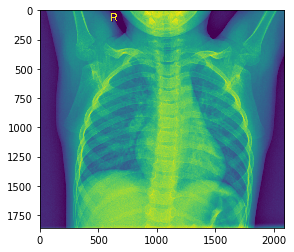

In [5]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

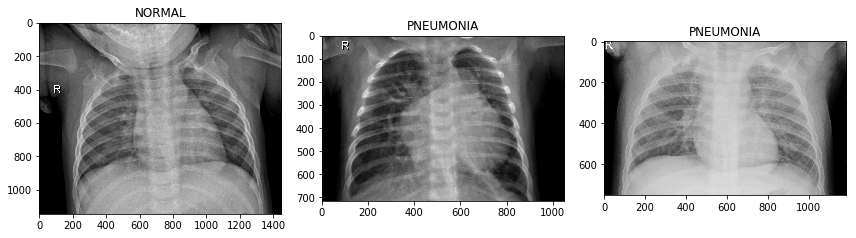

In [6]:
#visualize other images to check and see
img_normal = plt.imread('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

In [7]:
#create two files one with the images and another idication 0 for normal or 1 for pneumonia
def get_labeled_files(folder):
    x = []
    y = []
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                continue # we do not investigate other dirs
            for image_filename in os.listdir(folder + folderName):
                img_path = folder + folderName + '/' + image_filename
                if img_path is not None and str.endswith(img_path, 'jpeg'):
                    x.append(img_path)
                    y.append(label)
    
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

In [8]:
#lets list the last ten to see what it looks like by calling the above function
x, y = get_labeled_files('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/')

list(zip(x, y))[:10]


[('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1051-0001.jpeg',
  0),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1269-0001.jpeg',
  0),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0974-0001.jpeg',
  0),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0361-0001.jpeg',
  0),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0414-0001.jpeg',
  0),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0313-0001.jpeg',
  0),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0828-0001.jpeg',
  0),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0629-0001-0002.jpeg',
  0),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1423-0001.jpeg',
  0),
 ('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0274-0001.jpeg',
  0)]

In [9]:
#read and decode the jpegs and then resize them
NUM_CLASSES = 2

# This function takes image paths as arguments and reads corresponding images
def input_parser(img_path, label):
    # convert the label to one-hot encoding
    one_hot = tf.one_hot(label, NUM_CLASSES)
    # read the img from file and decode it using tf
    img_file = tf.read_file(img_path)
    img_decoded = tf.image.decode_jpeg(img_file, channels=3, name="decoded_images")
    return img_decoded, one_hot

# This function takes image and resizes it to smaller format (150x150)
def image_resize(images, labels):
    # Be very careful with resizing images like this and make sure to read the doc!
    # Otherwise, bad things can happen - https://hackernoon.com/how-tensorflows-tf-image-resize-stole-60-days-of-my-life-aba5eb093f35
    resized_image = tf.image.resize_images(images, (150, 150), align_corners=True)
    resized_image_asint = tf.cast(resized_image, tf.int32)
    return resized_image_asint, labels

In [10]:
#Create a pipeline for images to go to tensors

# Execution plan is defined here.
# Since it uses lazy evaluation, the images will not be read after calling build_pipeline_plan()
# We need to use iterator defined here in tf context
def build_pipeline_plan(img_paths, labels, batch_size):

    # We build a tensor of image paths and labels
    tr_data = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    # First step of input pipeline - read images in paths as jpegs
    tr_data_imgs = tr_data.map(input_parser)
    # Apply resize to each image in the pipeline
    tr_data_imgs = tr_data_imgs.map(image_resize)
    # Gives us opportuinty to batch images into small groups
    tr_dataset = tr_data_imgs.batch(batch_size)
    # create TensorFlow Iterator object directly from input pipeline
    iterator = tr_dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    return next_element

# Function to execute defined pipeline in Tensorflow session
def process_pipeline(next_element):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # get each element of the training dataset until the end is reached
        # in our case only one iteration since we read everything as 1 batch
        # can be multiple iterations if we decrease BATCH_SIZE to eg. 10
        images = []
        labels_hot = []
        while True:
            try:
                elem = sess.run(next_element)
                images = elem[0]
                labels_hot = elem[1]
            except tf.errors.OutOfRangeError:
                print("Finished reading the dataset")
                return images, labels_hot

In [11]:
#Get the images and labels
def load_dataset(path, batch_size):
    tf.reset_default_graph()
    files, labels = get_labeled_files(path)
    p = tf.constant(files, name="train_imgs")
    l = tf.constant(labels, name="train_labels")
    
    next_element = build_pipeline_plan(p, l, batch_size=batch_size)
    imgs, labels = process_pipeline(next_element)
    return imgs, labels

In [12]:
#see what the data looks like using our load dataset function from above
x_train, y_train = load_dataset("../input/chest-xray-pneumonia/chest_xray/chest_xray/train/", 6000)
x_test, y_test = load_dataset("../input/chest-xray-pneumonia/chest_xray/chest_xray/test/", 6000)
x_val, y_val = load_dataset("../input/chest-xray-pneumonia/chest_xray/chest_xray/val/", 6000)


Finished reading the dataset
Finished reading the dataset
Finished reading the dataset


In [13]:
#Find the sizes of the datasets
print("Training Dataset")
print(x_train.shape)
print(y_train.shape)
print("\nTesting Dataset")
print(x_test.shape)
print(y_test.shape)
print("\n Validation  Dataset")
print(x_val.shape)
print(y_val.shape)

Training Dataset
(5216, 150, 150, 3)
(5216, 2)

Testing Dataset
(624, 150, 150, 3)
(624, 2)

 Validation  Dataset
(16, 150, 150, 3)
(16, 2)


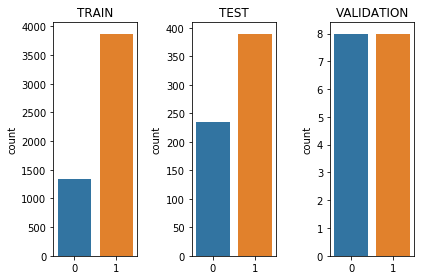

In [14]:
#calculate what is in each dataset and visualize it

plt.subplot(1,3,1)
sns.countplot(np.argmax(y_train, axis=1)).set_title('TRAIN')

plt.subplot(1,3,2)
sns.countplot(np.argmax(y_test, axis=1)).set_title('TEST')

plt.subplot(1,3,3)
sns.countplot(np.argmax(y_val, axis=1)).set_title('VALIDATION')

plt.tight_layout()

In [15]:
#start to build two models one on vgg16 and other on inception_v3
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

K.clear_session()

NUM_CLASSES = 2

#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
#base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
#base_model = DenseNet(blocks=10, weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()


Using TensorFlow backend.


87916544/87910968 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________

In [16]:
#create a function to show layers of model
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

In [17]:
#train bottom layers
for layer in model.layers[0:18]:
    layer.trainable = False
    
print_layers(model)

layer 0: input_1, trainable: False
layer 1: conv2d_1, trainable: False
layer 2: batch_normalization_1, trainable: False
layer 3: activation_1, trainable: False
layer 4: conv2d_2, trainable: False
layer 5: batch_normalization_2, trainable: False
layer 6: activation_2, trainable: False
layer 7: conv2d_3, trainable: False
layer 8: batch_normalization_3, trainable: False
layer 9: activation_3, trainable: False
layer 10: max_pooling2d_1, trainable: False
layer 11: conv2d_4, trainable: False
layer 12: batch_normalization_4, trainable: False
layer 13: activation_4, trainable: False
layer 14: conv2d_5, trainable: False
layer 15: batch_normalization_5, trainable: False
layer 16: activation_5, trainable: False
layer 17: max_pooling2d_2, trainable: False
layer 18: conv2d_9, trainable: True
layer 19: batch_normalization_9, trainable: True
layer 20: activation_9, trainable: True
layer 21: conv2d_7, trainable: True
layer 22: conv2d_10, trainable: True
layer 23: batch_normalization_7, trainable: True

In [18]:
model.trainable_weights

[<tf.Variable 'conv2d_9/kernel:0' shape=(1, 1, 192, 64) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_9/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv2d_7/kernel:0' shape=(1, 1, 192, 48) dtype=float32_ref>,
 <tf.Variable 'conv2d_10/kernel:0' shape=(3, 3, 64, 96) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_7/beta:0' shape=(48,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_10/beta:0' shape=(96,) dtype=float32_ref>,
 <tf.Variable 'conv2d_6/kernel:0' shape=(1, 1, 192, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d_8/kernel:0' shape=(5, 5, 48, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d_11/kernel:0' shape=(3, 3, 96, 96) dtype=float32_ref>,
 <tf.Variable 'conv2d_12/kernel:0' shape=(1, 1, 192, 32) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_6/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_8/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_11/beta:0' shape=(96,) dtype=float32_ref>,
 <tf

In [19]:
import numpy as np
import keras.backend as K
from itertools import product
from functools import partial


Use the "cross-entropy" loss function

See e.g.: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy

In [20]:
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask


w_array = np.ones((2,2))
w_array[1,0] = 30 # penalizing FN
w_array[0,1] = 1 # penalizing FP

spec_loss = lambda y_true, y_pred: w_categorical_crossentropy(y_true, y_pred, weights=w_array)

In [21]:
# Loss Function object
optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',     #  loss=spec_loss,
              optimizer=optimizer, 
              metrics=['accuracy'])

In [22]:
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

# This callback saves the wieights of the model after each epoch
checkpoint = ModelCheckpoint(
    'model/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# This callback writes logs for TensorBoard
tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)

In [23]:
#Calculate class weights for unbalanced set
from sklearn.utils import class_weight
y_labels = np.argmax(y_train, axis=1)
classweight = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
print(classweight)

[1.9448173  0.67303226]


In [24]:
#store the model weights
# prepare a directory to store the model weights
os.makedirs('./model', exist_ok=True)

history = model.fit(
    x=x_train, y=y_train,
    class_weight=classweight,
    validation_split=0.3,
    callbacks=[tensorboard],
    shuffle=True,
    batch_size=256,
    epochs=25,
    verbose=1
)

Train on 3651 samples, validate on 1565 samples
Epoch 1/25
3651/3651 [==============================] - 23s 6ms/step - loss: 0.3291 - acc: 0.8598 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/25
3651/3651 [==============================] - 8s 2ms/step - loss: 0.0328 - acc: 0.9907 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/25
3651/3651 [==============================] - 8s 2ms/step - loss: 0.0124 - acc: 0.9967 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/25
3651/3651 [==============================] - 8s 2ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/25
3651/3651 [==============================] - 8s 2ms/step - loss: 8.2983e-04 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 6/25
3651/3651 [==============================] - 8s 2ms/step - loss: 2.6006e-04 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 7/25
3651/3651 [==============================] - 8s 2ms/step - loss: 1.5942e-04 - acc: 1.0000 - val_loss: 1.

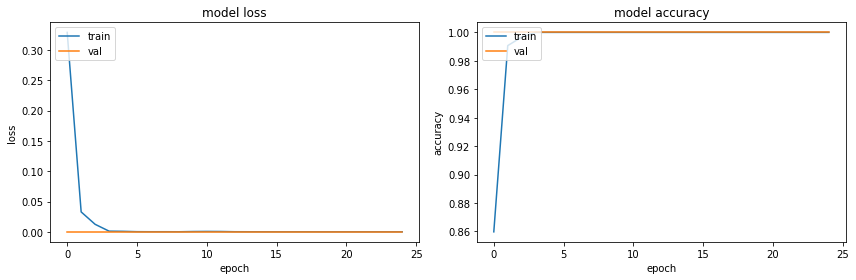

In [25]:
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    
plot_learning_curves(history)

In [26]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

Model Loss: 6.0442858445338805, Accuracy: 0.625
